In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import fashion_mnist
import tensorflow as tf
from keras import models
from keras import layers
from keras import regularizers
from keras.utils import to_categorical
from sklearn.model_selection import KFold
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
def pre_processamento():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    train_images = train_images.reshape((60000,28,28,1))
    train_images = train_images.astype('float32')/255 # Modificar os valores de cada pixel para que eles variem de 0 a 1 melhorará a taxa de aprendizado do nosso modelo.

    test_images = test_images.reshape((10000,28,28,1))
    test_images = test_images.astype('float32')/255 # Modificar os valores de cada pixel para que eles variem de 0 a 1 melhorará a taxa de aprendizado do nosso modelo.

    train_labels = to_categorical(train_labels) # Nosso modelo não pode trabalhar com dados categóricos diretamente. Portanto, devemos usar uma codificação quente. Em uma codificação ativa, os dígitos de 0 a 9 são representados como um conjunto de nove zeros e um único. O dígito é determinado pela localização do número 1. Por exemplo, você representaria um 3 como [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    test_labels = to_categorical(test_labels) # one hot encoding

    return train_images, train_labels, test_images, test_labels

# Definir a arquitetura da MLP
def criar_modelo_mlp(num_neuronios, num_camadas):

    camadas = [num_neuronios] * num_camadas # lista contendo a quantidade de neurônios desejada repetida 'num_camadas'

    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    for neurons in camadas:
        model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def criar_grafico(df, titulo):
    plt.cla()
    plt.plot(df['acuracia'], 'b', marker='.', label='acurácia', linewidth=3, markersize=12)
    plt.title(titulo)
    plt.legend()
    plt.savefig(titulo+".png", format='png', dpi=300, facecolor='white')


Treinando fold 1, com 1 camada(s) oculta, com 25 neurônios
Epoch 1/5
750/750 - 2s - loss: 0.6313 - accuracy: 0.7875 - 2s/epoch - 2ms/step
Epoch 2/5
750/750 - 1s - loss: 0.4589 - accuracy: 0.8405 - 945ms/epoch - 1ms/step
Epoch 3/5
750/750 - 1s - loss: 0.4170 - accuracy: 0.8542 - 883ms/epoch - 1ms/step
Epoch 4/5
750/750 - 1s - loss: 0.3951 - accuracy: 0.8622 - 885ms/epoch - 1ms/step
Epoch 5/5
750/750 - 1s - loss: 0.3779 - accuracy: 0.8661 - 848ms/epoch - 1ms/step
375/375 - 0s - loss: 0.3851 - accuracy: 0.8642 - 474ms/epoch - 1ms/step
Treinando fold 2, com 1 camada(s) oculta, com 25 neurônios
Epoch 1/5
750/750 - 1s - loss: 0.6303 - accuracy: 0.7852 - 1s/epoch - 2ms/step
Epoch 2/5
750/750 - 1s - loss: 0.4582 - accuracy: 0.8394 - 1s/epoch - 1ms/step
Epoch 3/5
750/750 - 1s - loss: 0.4161 - accuracy: 0.8528 - 1s/epoch - 1ms/step
Epoch 4/5
750/750 - 1s - loss: 0.3948 - accuracy: 0.8615 - 1s/epoch - 1ms/step
Epoch 5/5
750/750 - 1s - loss: 0.3776 - accuracy: 0.8654 - 912ms/epoch - 1ms/step
375/3

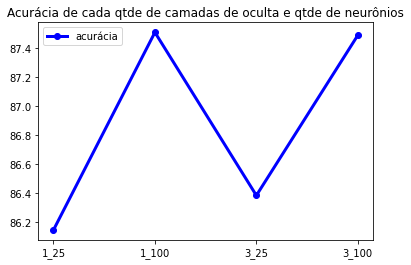

In [12]:
### Main
train_images, train_labels, test_images, test_labels = pre_processamento()


k_folds = 5

cv = KFold(n_splits=k_folds, shuffle=True, random_state=42) # vamos embaralhá-los antes de dividi-lo, seed 42

# --------- Testar diferentes quantidades de camadas e de neurônios ------------
lista_num_camadas = [1, 3]  # Quantidade de neurônios em cada camada
lista_num_neuronios = [25, 100]  # Quantidade de camadas escondidas

dct_camada_neuronio = {}
melhor_acc = 0
melhor_num_camada = 0
melhor_num_neuronio = 0
for num_camadas in lista_num_camadas:
    for num_neuronios in lista_num_neuronios:
        fold_no = 1 #contador
        acc_per_fold = [] #acurácia de cada fold
        for train, test in cv.split(train_images, train_labels): #pra cada fold
            print(f"Treinando fold {fold_no}, com {num_camadas} camada(s) oculta, com {num_neuronios} neurônios" )
            train_X = train_images[train]
            test_X = train_images[test]
            model = criar_modelo_mlp(num_neuronios, num_camadas)
            model.fit(train_X, train_labels[train], epochs=5, batch_size=64, verbose=2)
            test_loss, test_acc = model.evaluate(test_X, train_labels[test], verbose=2)
            acc_per_fold.append(test_acc * 100)
            fold_no = fold_no + 1

        media_acc_camada_neuronio = sum(acc_per_fold)/len(acc_per_fold)

        dct_camada_neuronio.update({str(num_camadas)+"_"+str(num_neuronios): {"acuracia": media_acc_camada_neuronio}})

        print(f"Média acurácia dos 5 folds pra {num_camadas} camada(s) oculta, com {num_neuronios} neurônios:", media_acc_camada_neuronio)
        print(f"Essa acurácia significa que o modelo usando {num_camadas} camada(s) oculta, com {num_neuronios} neurônios, usando a função ReLu para os neurônios das camadas ocultas e SoftMax para a saída é capaz de classificar corretamente em média {round(media_acc_camada_neuronio, 1)}% das imagens")
        if media_acc_camada_neuronio > melhor_acc:
            melhor_acc = media_acc_camada_neuronio
            melhor_num_camada = num_camadas
            melhor_num_neuronio = num_neuronios
print(f"Portanto, a melhor quantidade de camada(s) oculta é {melhor_num_camada}, com {melhor_num_neuronio} neurônios, que possui {round(melhor_acc, 1)} de acurácia.")
dfCamadaNeuronio = pd.DataFrame(dct_camada_neuronio).T
titulo = "Acurácia de cada qtde de camadas de oculta e qtde de neurônios"
criar_grafico(dfCamadaNeuronio, titulo)

In [18]:
melhor_num_camada
melhor_num_neuronio

100

In [19]:
def criar_modelo_mlp_regularizacao(num_neuronios, num_camadas, taxa_regularizacao):

    camadas = [num_neuronios] * num_camadas # lista contendo a quantidade de neurônios desejada repetida 'num_camadas'
    
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    for neurons in camadas:
        model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(taxa_regularizacao)))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Treinando fold 1, com 1 camada(s) oculta, com 100 neurônios e 0.001 de taxa de regularização L2
Epoch 1/5
750/750 - 2s - loss: 0.6957 - accuracy: 0.8004 - 2s/epoch - 3ms/step
Epoch 2/5
750/750 - 1s - loss: 0.5286 - accuracy: 0.8451 - 1s/epoch - 2ms/step
Epoch 3/5
750/750 - 1s - loss: 0.4827 - accuracy: 0.8546 - 1s/epoch - 2ms/step
Epoch 4/5
750/750 - 1s - loss: 0.4561 - accuracy: 0.8602 - 1s/epoch - 2ms/step
Epoch 5/5
750/750 - 1s - loss: 0.4419 - accuracy: 0.8627 - 1s/epoch - 2ms/step
375/375 - 0s - loss: 0.4640 - accuracy: 0.8537 - 482ms/epoch - 1ms/step
Treinando fold 2, com 1 camada(s) oculta, com 100 neurônios e 0.001 de taxa de regularização L2
Epoch 1/5
750/750 - 1s - loss: 0.7176 - accuracy: 0.7909 - 1s/epoch - 2ms/step
Epoch 2/5
750/750 - 1s - loss: 0.5387 - accuracy: 0.8392 - 1s/epoch - 1ms/step
Epoch 3/5
750/750 - 1s - loss: 0.4879 - accuracy: 0.8526 - 1s/epoch - 2ms/step
Epoch 4/5
750/750 - 1s - loss: 0.4614 - accuracy: 0.8590 - 1s/epoch - 1ms/step
Epoch 5/5
750/750 - 1s - 

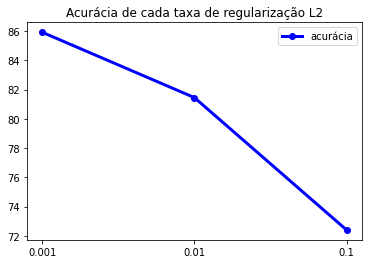

In [20]:
taxas_regularizacao = [0.001, 0.01, 0.1]  # Taxas de regularização L2 a serem testadas

dct_taxa_regularizacao = {}
melhor_acc = 0
melhor_taxa_regularizacao = 0
for taxa_regularizacao in taxas_regularizacao:
        fold_no = 1 #contador
        acc_per_fold = [] #acurácia de cada fold
        for train, test in cv.split(train_images, train_labels): #pra cada fold
            print(f"Treinando fold {fold_no}, com {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios e {taxa_regularizacao} de taxa de regularização L2" )
            train_X = train_images[train]
            test_X = train_images[test]
            model = criar_modelo_mlp_regularizacao(melhor_num_neuronio, melhor_num_camada, taxa_regularizacao)
            model.fit(train_X, train_labels[train], epochs=5, batch_size=64, verbose=2)
            test_loss, test_acc = model.evaluate(test_X, train_labels[test], verbose=2)
            acc_per_fold.append(test_acc * 100)
            fold_no = fold_no + 1

        media_acc_regularizacao = sum(acc_per_fold)/len(acc_per_fold)

        dct_taxa_regularizacao.update({str(taxa_regularizacao): {"acuracia": media_acc_regularizacao}})

        print(f"Média acurácia dos 5 folds pra {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios e {taxa_regularizacao} de taxa de regularização L2:", media_acc_regularizacao)
        print(f"Essa acurácia significa que o modelo usando {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios, com {taxa_regularizacao} de taxa de regularização L2 e usando a função ReLu para os neurônios das camadas ocultas e SoftMax para a saída é capaz de classificar corretamente em média {round(media_acc_regularizacao, 1)}% das imagens")
        if media_acc_regularizacao > melhor_acc:
            melhor_acc = media_acc_regularizacao
            melhor_taxa_regularizacao = taxa_regularizacao
print(f"Portanto, a melhor taxa de regularização L2 é {melhor_taxa_regularizacao}, que possui {round(melhor_acc, 1)} de acurácia.")
dfTaxaRegularizacao = pd.DataFrame(dct_taxa_regularizacao).T
titulo = "Acurácia de cada taxa de regularização L2"
criar_grafico(dfTaxaRegularizacao, titulo)